# Time Series Classification: Glucose Conditions

**Objective:** Classify CV_mCherry time series from two glucose conditions using machine learning

**Experiments:**
- 19316_2020_10_26_steadystate_glucose_144m_2w2_00 (2% glucose, label: 0)
- 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00 (0.01% glucose, label: 1)


## 1. Setup and Data Loading

In [1]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Custom imports
from wela.get_exp_conditions import get_exp_summary
from wela.calculate_stats import load_tsv

# Set seeds for reproducibility
np.random.seed(42)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/ianyang/micromamba/envs/wela/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ianyang/micromamba/envs/wela/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/ianyang/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/ianyang/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    a

AttributeError: _ARRAY_API not found

In [2]:
# Load experimental data
omids = [
    '19316_2020_10_26_steadystate_glucose_144m_2w2_00',  # 2% glucose
    '20213_2021_09_07_steady_0p01glc_1344_1346_1347_00'  # 0.01% glucose
]

# Load both experiments
data = {}
for i, omid in enumerate(omids):
    # Get experiment metadata
    acq_file = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omid}/*Acq.txt")[0]
    log_file = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omid}/*log.txt")[0]
    _, tf_df, _ = get_exp_summary(acq_file, log_file)
    
    # Load time series data
    tsv_path = f"/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/exp_data/{omid}_post_media_switch.tsv"
    df = load_tsv(tsv_path)[['CV_mCherry', 'group', 'time', 'id']]
    
    data[f'exp{i+1}'] = {'df': df, 'tf_df': tf_df, 'omid': omid}

=== EXPERIMENT SUMMARY ===

📸 IMAGING SETUP (from acquisition file):
• Channels: ['Brightfield', 'GFP', 'mCherry']
• Exposure times: [30, 30, 100] ms
• Camera EM gain: 270

⏱️ TIME-LAPSE SETTINGS:
• Time interval: 120 seconds (2.0 minutes)
• Number of timepoints: 540
• Total experiment time: 64800 seconds (18.0 hours)

🧪 MICROFLUIDICS SETUP:
• Number of pumps: 2
• Pump rates: [[0.0], [4.0]]
• Pump contents: ['2% glucose in SC', '2% glucose in SC']
• Number of switches: 1
• Switch volumes: 50
• Switch rates: 100
• Switch times: [180]

🔬 MICROSCOPE SETUP (from log file):
• Microscope: Batgirl
• Date: 2020-10-25 00:00:00
• Experiment start time: 2020-10-25 17:09:13
• Capture of the first image: 2020-10-25 17:09:14
• MultiDGUI commit: 29bfe736500ed3f8be9c19585bee78cc67ceae26
• Experimental details: Aim:   Strain:   Comments:   Strains 1344 and 1346 were both labelled 1346 in the subculturing so not sure which is which.

💾 OMERO INFORMATION:
• Project: SteadystateGlucose
• Tags: ['25-Oct-20

## 2. Data Visualization

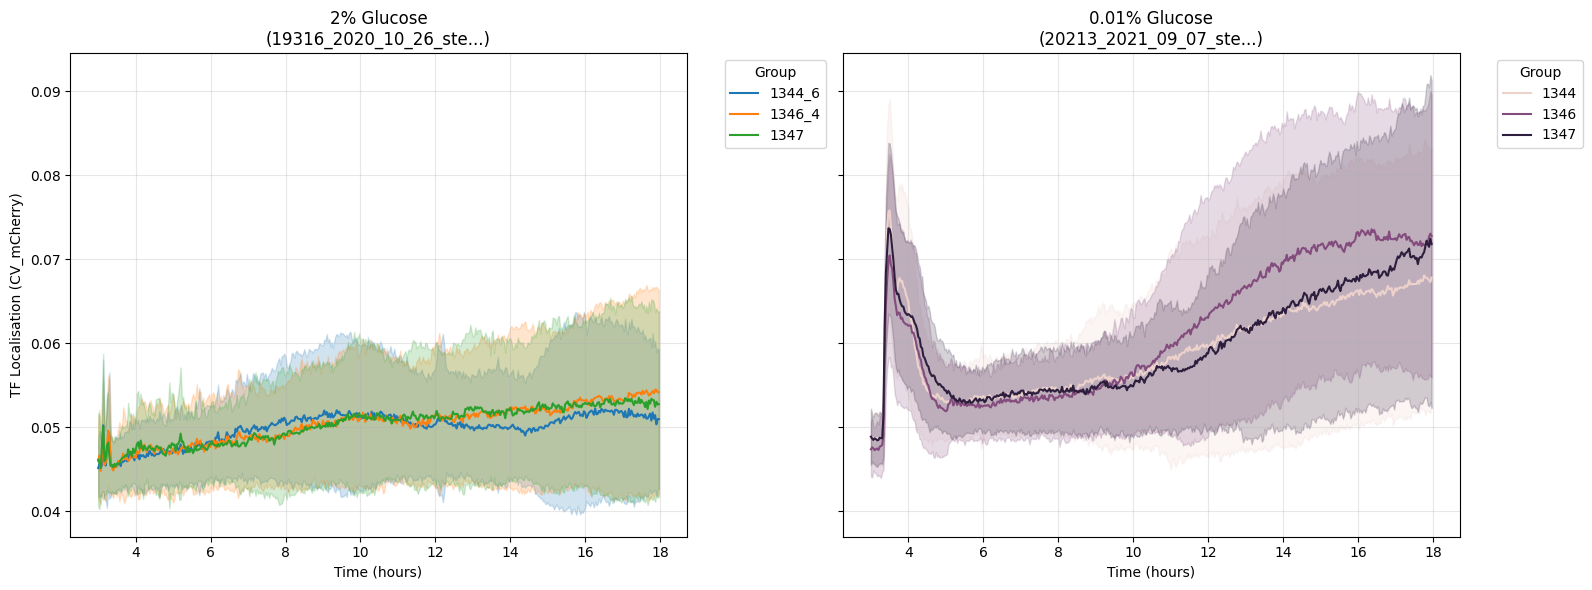

In [3]:
# Plot time series comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
conditions = ['2% Glucose', '0.01% Glucose']

for i, (exp_key, exp_data) in enumerate(data.items()):
    df = exp_data['df']
    sns.lineplot(data=df, x='time', y='CV_mCherry', hue='group', errorbar='sd', ax=axes[i])
    axes[i].set_title(f'{conditions[i]}\n({exp_data["omid"][:20]}...)')
    axes[i].set_xlabel('Time (hours)')
    axes[i].set_ylabel('TF Localisation (CV_mCherry)')
    axes[i].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing Pipeline

In [4]:
def create_time_series_matrix(df, experiment_name):
    """Convert long-format data to time series matrix format"""
    time_series_dict = {}
    groups = df['group'].unique()
    
    for group in groups:
        group_data = df[df['group'] == group]
        # Pivot: rows=id, columns=time, values=CV_mCherry
        pivot_df = group_data.pivot(index='id', columns='time', values='CV_mCherry').reset_index()
        pivot_df['group'] = group
        pivot_df['experiment'] = experiment_name
        
        # Reorder columns
        metadata_cols = ['id', 'group', 'experiment']
        time_cols = [col for col in pivot_df.columns if col not in metadata_cols]
        pivot_df = pivot_df[metadata_cols + sorted(time_cols)]
        
        time_series_dict[f'group_{group}'] = pivot_df
    
    return time_series_dict

# Convert both experiments to time series format
exp1_ts = create_time_series_matrix(data['exp1']['df'], data['exp1']['omid'])
exp2_ts = create_time_series_matrix(data['exp2']['df'], data['exp2']['omid'])

In [5]:
def handle_missing_values_dict(time_series_dict):
    """Handle missing values using iterative imputation"""
    processed_dict = {}
    
    for group_name, df in time_series_dict.items():
        metadata_cols = ['id', 'group', 'experiment']
        time_cols = [col for col in df.columns if col not in metadata_cols]
        
        if not time_cols:
            processed_dict[group_name] = df.copy()
            continue
        
        time_series_matrix = df[time_cols].values
        missing_pct = (np.isnan(time_series_matrix).sum() / time_series_matrix.size) * 100
        
        if missing_pct == 0:
            processed_matrix = time_series_matrix
        elif missing_pct > 90:
            # Simple interpolation for high missing data
            processed_matrix = time_series_matrix.copy()
            for i in range(processed_matrix.shape[0]):
                series = pd.Series(processed_matrix[i])
                series = series.interpolate().fillna(method='ffill').fillna(method='bfill')
                processed_matrix[i] = series.values
        else:
            # Iterative imputation
            try:
                imputer = IterativeImputer(estimator=LinearRegression(), random_state=42, verbose=0)
                processed_matrix = imputer.fit_transform(time_series_matrix)
            except:
                # Fallback to simple interpolation
                processed_matrix = time_series_matrix.copy()
                for i in range(processed_matrix.shape[0]):
                    series = pd.Series(processed_matrix[i])
                    series = series.interpolate().fillna(method='ffill').fillna(method='bfill')
                    processed_matrix[i] = series.values
        
        # Create processed dataframe
        processed_df = df.copy()
        processed_df[time_cols] = processed_matrix
        processed_dict[group_name] = processed_df
    
    return processed_dict

exp1_processed = handle_missing_values_dict(exp1_ts)
exp2_processed = handle_missing_values_dict(exp2_ts)

### Steady State Extraction

In [6]:
def _detect_initial_burst(values, time_points, burst_window=5, burst_threshold=0.2, min_burst_duration=3):
    """Detect initial burst phase where values are changing rapidly"""
    
    burst_end_idx = 0
    for i in range(burst_window, len(values) - min_burst_duration):
        if pd.isna(values[i]):
            continue
        
        window_values = values[max(0, i-burst_window):i]
        valid_window = window_values[~pd.isna(window_values)]
        
        if len(valid_window) < burst_window * 0.8:
            continue
        
        window_mean = np.mean(valid_window)
        window_std = np.std(valid_window)
        cv = window_std / abs(window_mean) if window_mean != 0 else 0
        
        if cv <= burst_threshold:
            # Check if stability persists
            is_stable_period = True
            for j in range(i, min(i + min_burst_duration, len(values))):
                if pd.isna(values[j]):
                    continue
                
                local_window = values[max(0, j-2):min(len(values), j+3)]
                valid_local = local_window[~pd.isna(local_window)]
                
                if len(valid_local) >= 3:
                    local_mean = np.mean(valid_local)
                    local_std = np.std(valid_local)
                    local_cv = local_std / abs(local_mean) if local_mean != 0 else 0
                    
                    if local_cv > burst_threshold:
                        is_stable_period = False
                        break
            
            if is_stable_period:
                burst_end_idx = i
                break
    
    return burst_end_idx

def extract_steady_state(time_series_dict, window_size=10, tolerance=0.10, min_steady_duration=3, burst_threshold=0.10):
    """Extract steady state periods from time series data"""
    steady_dict = {}
    
    for group, df in time_series_dict.items():
        time_cols = [col for col in df.columns if isinstance(col, (int, float))]
        time_cols = sorted(time_cols)
        
        steady_start_times = []
        steady_end_times = []
        
        # Analyze each time series for steady state
        for idx, row in df.iterrows():
            series_values = row[time_cols].values
            valid_mask = ~pd.isna(series_values)
            if np.sum(valid_mask) < window_size + min_steady_duration:
                continue
            
            # Detect burst end
            burst_end_idx = _detect_initial_burst(series_values, time_cols, burst_threshold=burst_threshold)
            analysis_start_idx = max(burst_end_idx, window_size)
            
            if analysis_start_idx >= len(series_values) - min_steady_duration:
                continue
            
            # Calculate sliding window means
            window_means = []
            window_time_points = []
            for i in range(analysis_start_idx, len(time_cols) - window_size + 1):
                window_values = series_values[i:i + window_size]
                if np.sum(~pd.isna(window_values)) >= window_size * 0.8:
                    window_means.append(np.nanmean(window_values))
                    window_time_points.append(time_cols[i + window_size - 1])
                else:
                    window_means.append(np.nan)
                    window_time_points.append(time_cols[i + window_size - 1])
            
            # Find steady state start
            steady_start_idx = None
            for i in range(len(window_means) - min_steady_duration):
                if pd.isna(window_means[i]):
                    continue
                
                reference_mean = window_means[i] if window_means[i] != 0 else 1e-10
                
                # Check consecutive windows within tolerance
                is_steady = True
                for j in range(i + 1, min(i + 1 + min_steady_duration, len(window_means))):
                    if pd.isna(window_means[j]):
                        is_steady = False
                        break
                    relative_diff = abs(window_means[j] - reference_mean) / abs(reference_mean)
                    if relative_diff > tolerance:
                        is_steady = False
                        break
                
                if is_steady:
                    steady_start_idx = i
                    break
            
            # Detect end of steady state
            steady_end_idx = None
            if steady_start_idx is not None:
                # Look for end starting from steady_start_idx
                for i in range(steady_start_idx + min_steady_duration, len(window_means) - min_steady_duration):
                    if pd.isna(window_means[i]):
                        continue
                    
                    # Use established steady state mean as reference
                    reference_mean = window_means[steady_start_idx] if window_means[steady_start_idx] != 0 else 1e-10
                    current_diff = abs(window_means[i] - reference_mean) / abs(reference_mean)
                    
                    if current_diff > tolerance:
                        # Check if deviation persists
                        is_end_steady = True
                        for j in range(i + 1, min(i + 1 + min_steady_duration, len(window_means))):
                            if pd.isna(window_means[j]):
                                continue
                            next_diff = abs(window_means[j] - reference_mean) / abs(reference_mean)
                            if next_diff <= tolerance:
                                is_end_steady = False
                                break
                        
                        if is_end_steady:
                            steady_end_idx = i
                            break
            
            # Store results
            if steady_start_idx is not None:
                steady_start_times.append(window_time_points[steady_start_idx])
                if steady_end_idx is not None:
                    steady_end_times.append(window_time_points[steady_end_idx])
                else:
                    steady_end_times.append(np.nan)
        
        # Filter to steady state period
        if steady_start_times:
            start_time = np.median([t for t in steady_start_times if not pd.isna(t)])
            end_times = [t for t in steady_end_times if not pd.isna(t)]
            end_time = np.median(end_times) if end_times else None
            
            if end_time is not None:
                steady_time_cols = [col for col in time_cols if start_time <= col <= end_time]
            else:
                steady_time_cols = [col for col in time_cols if col >= start_time]
            
            if steady_time_cols:
                filtered_df = df[['id', 'group', 'experiment'] + steady_time_cols].copy()
                filtered_df = filtered_df.dropna(subset=steady_time_cols, how='all')
                steady_dict[group] = filtered_df
    
    return steady_dict

In [34]:
# Extract steady state from processed data
exp1_steady_state = extract_steady_state(exp1_processed, window_size=30, tolerance=0.10, min_steady_duration=5, burst_threshold=0.05)
exp2_steady_state = extract_steady_state(exp2_processed, window_size=30, tolerance=0.10, min_steady_duration=5, burst_threshold=0.05)

print(f"Steady state extraction complete:")
for exp_name, exp_dict in [("Exp1", exp1_steady_state), ("Exp2", exp2_steady_state)]:
    for group_name, df in exp_dict.items():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        print(f"  {exp_name} {group_name}: {df.shape[0]} series × {len(time_cols)} timepoints")

Steady state extraction complete:
  Exp1 group_1344_6: 71 series × 94 timepoints
  Exp1 group_1346_4: 84 series × 127 timepoints
  Exp1 group_1347: 78 series × 126 timepoints
  Exp2 group_1344: 241 series × 146 timepoints
  Exp2 group_1346: 231 series × 105 timepoints
  Exp2 group_1347: 275 series × 89 timepoints


In [8]:
def plot_time_series_overview(time_series_dict, experiment_name, max_series=5):
    """Plot overview of time series data for each group"""
    
    fig, axes = plt.subplots(len(time_series_dict), 1, figsize=(15, 4*len(time_series_dict)))
    if len(time_series_dict) == 1:
        axes = [axes]
    
    for idx, (group_name, df) in enumerate(time_series_dict.items()):
        ax = axes[idx]
        
        # Get time columns (exclude metadata columns)
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        time_values = [float(col) for col in time_cols]
        
        # Plot first few time series
        n_series = min(max_series, len(df))
        for i in range(n_series):
            cv_values = df.iloc[i][time_cols].values
            # Only plot non-NaN values
            valid_mask = ~pd.isna(cv_values)
            if valid_mask.any():
                ax.plot([time_values[j] for j in range(len(time_values)) if valid_mask[j]], 
                       cv_values[valid_mask], alpha=0.7, label=f'ID {df.iloc[i]["id"]}')
        
        ax.set_title(f'{experiment_name} - {group_name}\n({len(df)} total time series)')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('CV_mCherry')
        ax.grid(True, alpha=0.3)
        if n_series <= 10:  # Only show legend if not too many series
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

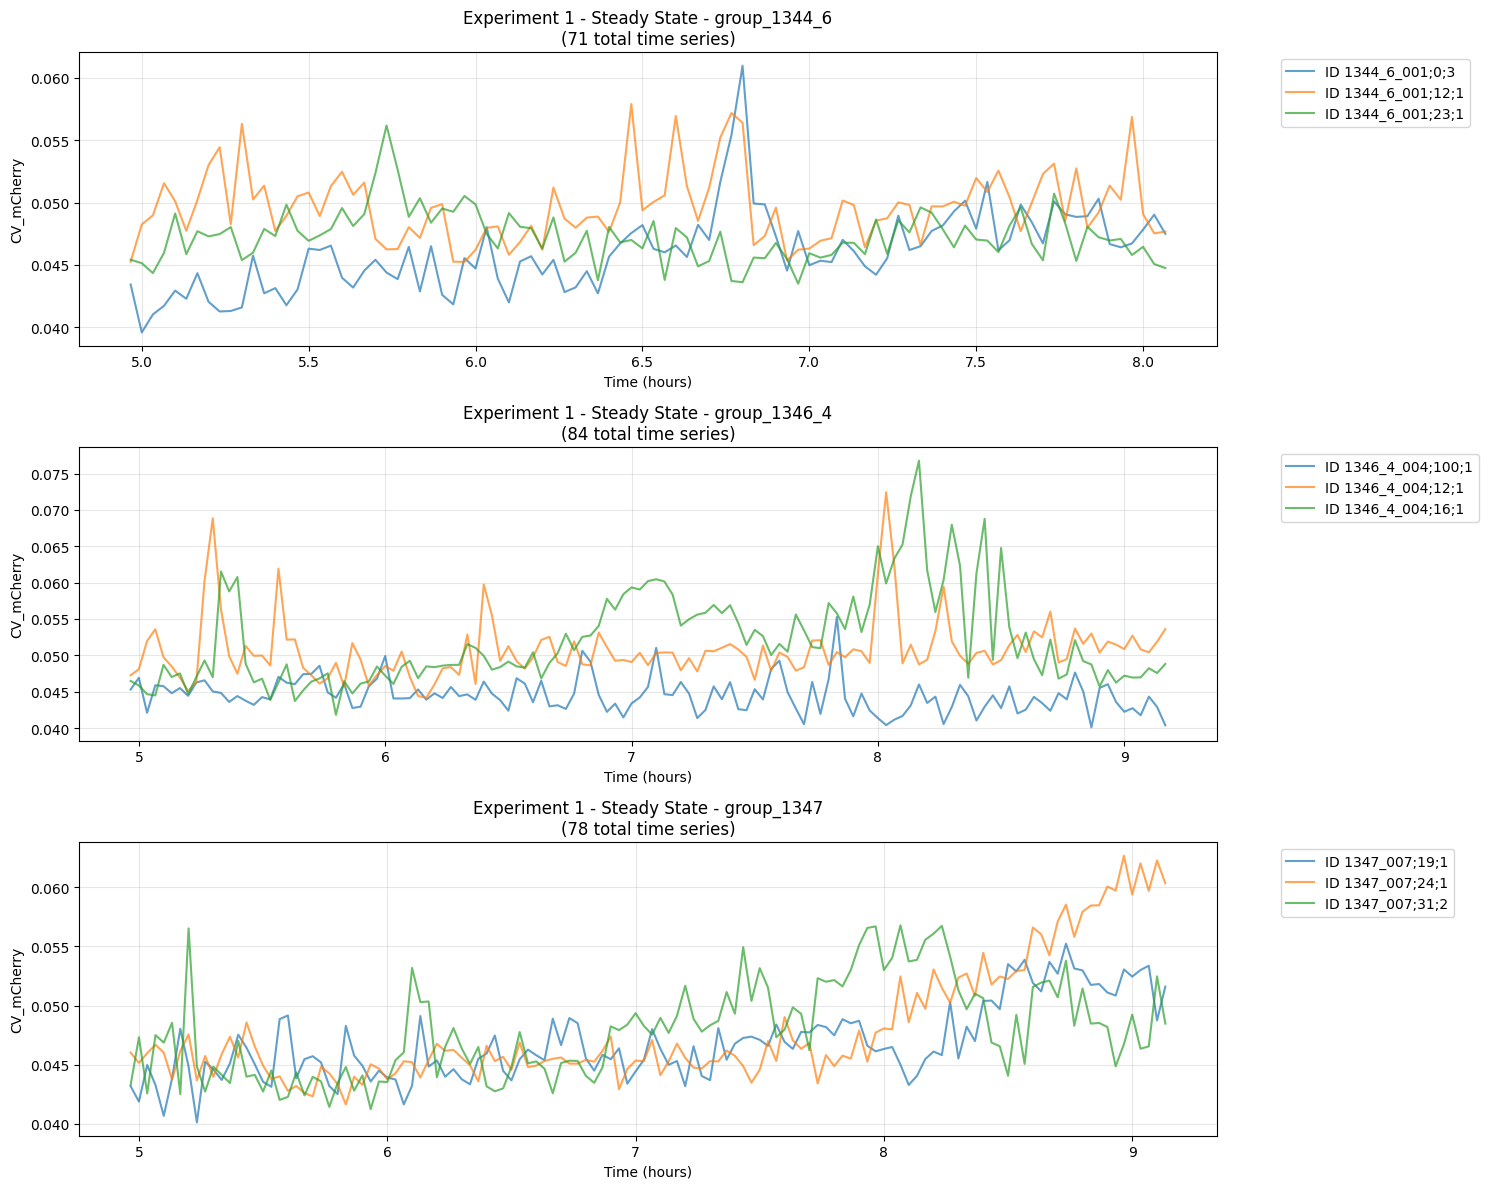

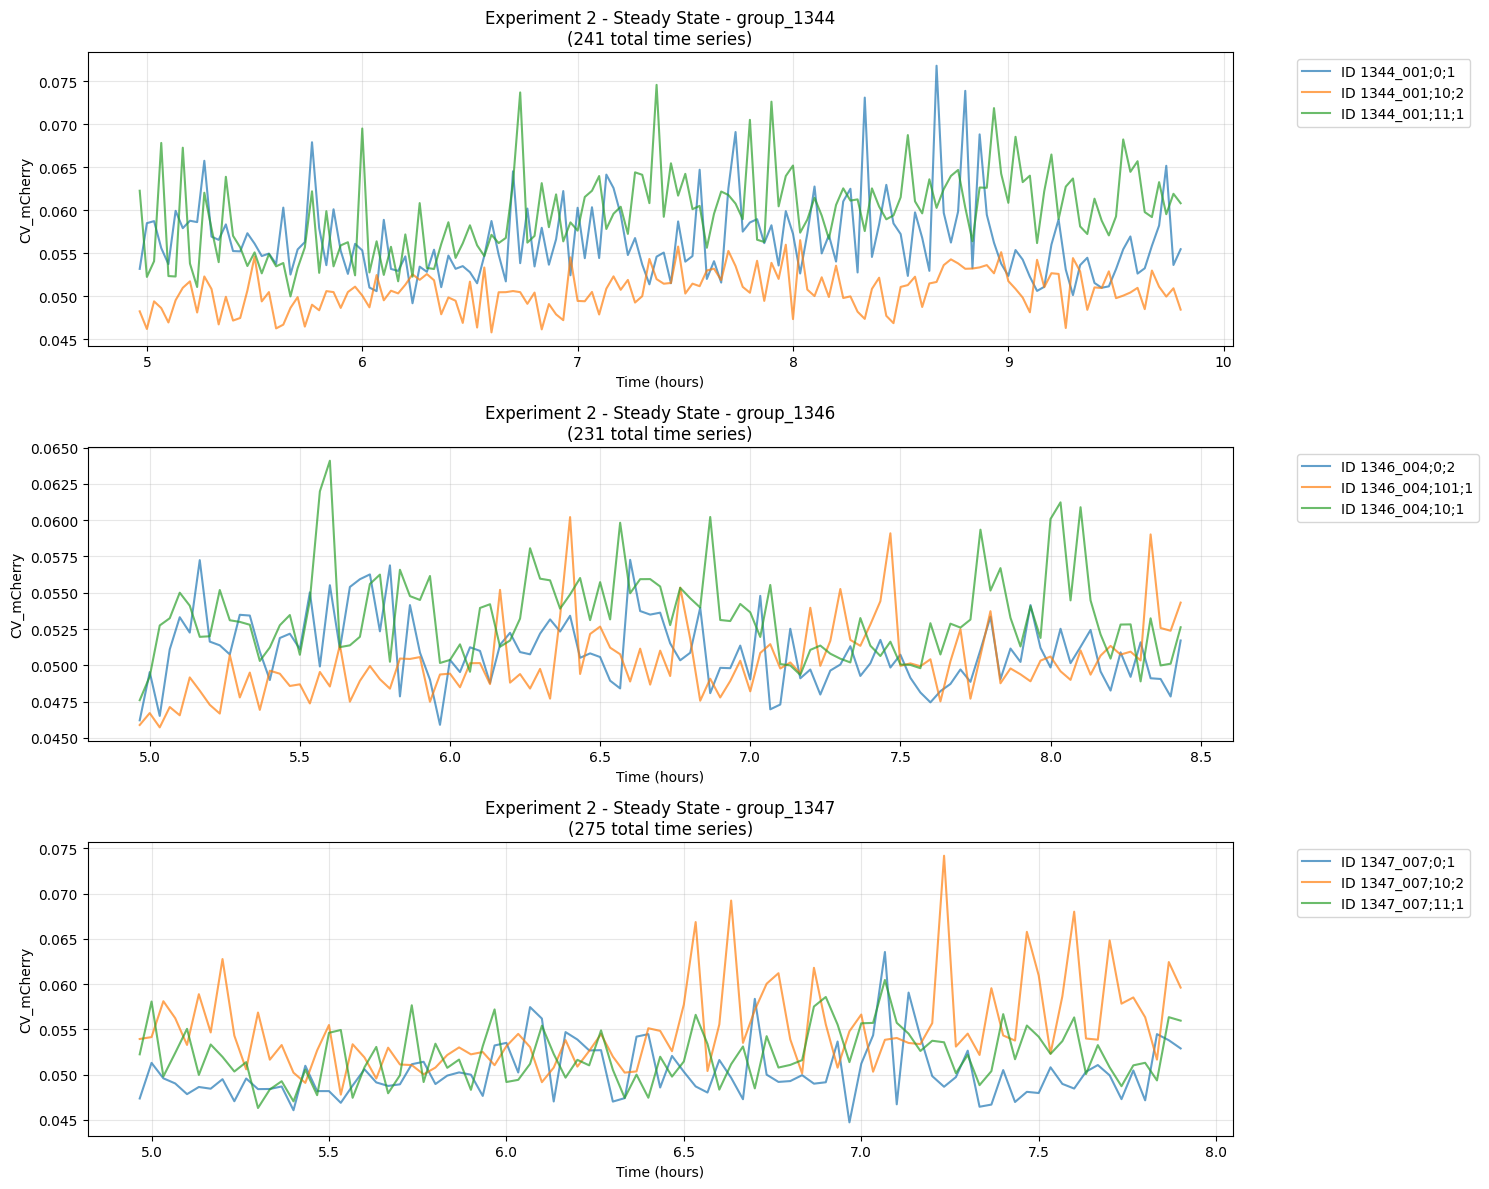

In [19]:
plot_time_series_overview(exp1_steady_state, "Experiment 1 - Steady State", max_series=3)
plot_time_series_overview(exp2_steady_state, "Experiment 2 - Steady State", max_series=3)

In [20]:
def balance_dataset_dimensions(exp1_dict, exp2_dict):
    """Balance number of series and timepoints across experiments"""
    # Find minimum number of series across all groups
    min_series_exp1 = min(df.shape[0] for df in exp1_dict.values())
    min_series_exp2 = min(df.shape[0] for df in exp2_dict.values())
    min_series = min(min_series_exp1, min_series_exp2)
    
    # Balance number of series
    exp1_balanced = {k: df.iloc[:min_series] for k, df in exp1_dict.items()}
    exp2_balanced = {k: df.iloc[:min_series] for k, df in exp2_dict.items()}
    
    # Find minimum number of timepoints
    def get_min_timepoints(exp_dict):
        min_tp = float('inf')
        for df in exp_dict.values():
            time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
            min_tp = min(min_tp, len(time_cols))
        return min_tp
    
    min_timepoints = min(get_min_timepoints(exp1_balanced), get_min_timepoints(exp2_balanced))
    
    # Truncate to minimum timepoints
    def truncate_timepoints(exp_dict, min_tp):
        truncated = {}
        for group_name, df in exp_dict.items():
            metadata_cols = ['id', 'group', 'experiment']
            time_cols = sorted([col for col in df.columns if col not in metadata_cols])
            selected_cols = metadata_cols + time_cols[:min_tp]
            truncated[group_name] = df[selected_cols].copy()
        return truncated
    
    exp1_final = truncate_timepoints(exp1_balanced, min_timepoints)
    exp2_final = truncate_timepoints(exp2_balanced, min_timepoints)
    
    print(f"Balanced to: {min_series} series per group, {min_timepoints} timepoints")
    return exp1_final, exp2_final

# Balance datasets
exp1_balanced, exp2_balanced = balance_dataset_dimensions(exp1_steady_state, exp2_steady_state)

Balanced to: 71 series per group, 89 timepoints


## 4. Create Machine Learning Dataset

In [21]:
def create_ml_dataset(exp1_dict, exp2_dict):
    """Create final ML dataset with labels"""
    X_list, y_list = [], []
    
    # Process experiment 1 (label = 0)
    for df in exp1_dict.values():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        for _, row in df.iterrows():
            series_values = row[time_cols].values
            if np.sum(~pd.isna(series_values)) / len(series_values) >= 0.5:  # At least 50% valid data
                X_list.append(series_values)
                y_list.append(0)
    
    # Process experiment 2 (label = 1)
    for df in exp2_dict.values():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        for _, row in df.iterrows():
            series_values = row[time_cols].values
            if np.sum(~pd.isna(series_values)) / len(series_values) >= 0.5:
                X_list.append(series_values)
                y_list.append(1)
    
    # Convert to numpy arrays with proper dtype
    X = np.stack([np.asarray(series, dtype=np.float64) for series in X_list])
    y = np.array(y_list, dtype=int)
    
    return X, y

# Create final dataset
X, y = create_ml_dataset(exp1_balanced, exp2_balanced)

print(f"Final dataset: {X.shape[0]} samples × {X.shape[1]} timepoints")
print(f"Label distribution: {np.bincount(y)} (0=2% glucose, 1=0.01% glucose)")
print(f"Data range: [{X.min():.3f}, {X.max():.3f}]")

Final dataset: 426 samples × 89 timepoints
Label distribution: [213 213] (0=2% glucose, 1=0.01% glucose)
Data range: [0.031, 0.102]


## 5. Data Analysis and Visualization

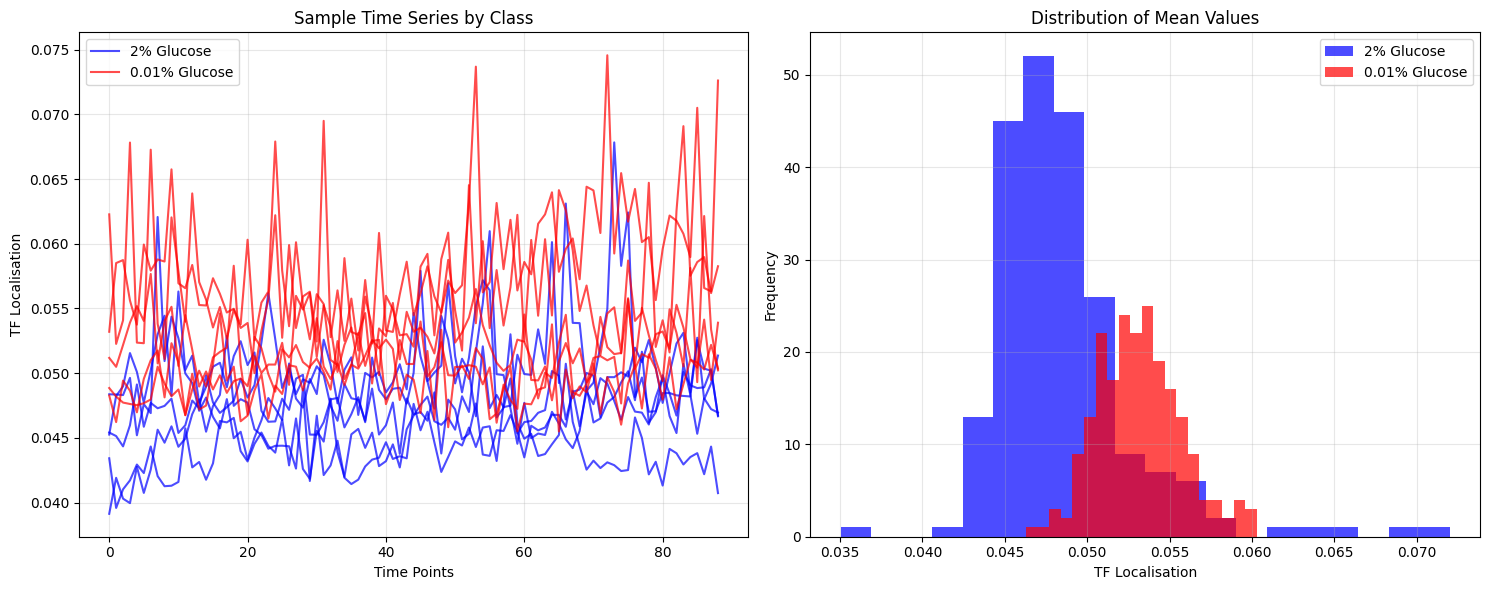

2% Glucose mean: 0.049 ± 0.004
0.01% Glucose mean: 0.053 ± 0.003


In [22]:
# Analyze class differences
from scipy import stats

class_0_means = [np.mean(X[i]) for i in range(len(X)) if y[i] == 0]
class_1_means = [np.mean(X[i]) for i in range(len(X)) if y[i] == 1]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sample time series
class_0_indices = np.where(y == 0)[0][:5]
class_1_indices = np.where(y == 1)[0][:5]

for i in class_0_indices:
    axes[0].plot(X[i], alpha=0.7, color='blue', label='2% Glucose' if i == class_0_indices[0] else "")
for i in class_1_indices:
    axes[0].plot(X[i], alpha=0.7, color='red', label='0.01% Glucose' if i == class_1_indices[0] else "")

axes[0].set_title('Sample Time Series by Class')
axes[0].set_xlabel('Time Points')
axes[0].set_ylabel('TF Localisation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Mean distribution
axes[1].hist(class_0_means, alpha=0.7, label='2% Glucose', bins=20, color='blue')
axes[1].hist(class_1_means, alpha=0.7, label='0.01% Glucose', bins=20, color='red')
axes[1].set_title('Distribution of Mean Values')
axes[1].set_xlabel('TF Localisation')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Class means comparison
# class_means = [np.mean(class_0_means), np.mean(class_1_means)]
# class_stds = [np.std(class_0_means), np.std(class_1_means)]
# colors = ['blue', 'red']
# labels = ['2% Glucose', '0.01% Glucose']

# bars = axes[2].bar(labels, class_means, yerr=class_stds, color=colors, alpha=0.7, capsize=5)
# axes[2].set_title('Mean CV_mCherry by Condition')
# axes[2].set_ylabel('Mean CV_mCherry')
# axes[2].grid(True, alpha=0.3)

# # Add values on bars
# for bar, mean, std in zip(bars, class_means, class_stds):
#     axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.001,
#                 f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"2% Glucose mean: {np.mean(class_0_means):.3f} ± {np.std(class_0_means):.3f}")
print(f"0.01% Glucose mean: {np.mean(class_1_means):.3f} ± {np.std(class_1_means):.3f}")

## 6. Machine Learning Classification

In [23]:
# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train labels: {np.bincount(y_train)}")
print(f"Test labels: {np.bincount(y_test)}")

Train labels: [127 128]
Test labels: [43 43]


In [24]:
# SVM Classification
svm_model = SVC(C=1.0, gamma='scale', kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=['2% Glucose', '0.01% Glucose']))

SVM Accuracy: 0.8488

Classification Report:
               precision    recall  f1-score   support

   2% Glucose       0.83      0.88      0.85        43
0.01% Glucose       0.88      0.81      0.84        43

     accuracy                           0.85        86
    macro avg       0.85      0.85      0.85        86
 weighted avg       0.85      0.85      0.85        86



In [25]:
# Import and run deep learning classifiers
import sys
from pathlib import Path
sys.path.append(str(Path("/home/ianyang/stochastic_simulations/src").resolve()))
from classifiers.lstm_classifier import lstm_classifier
from classifiers.transformer_classifier import transformer_classifier

# LSTM
lstm_accuracy = lstm_classifier(
    X_train, X_val, X_test, y_train, y_val, y_test,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)

# Transformer
transformer_accuracy = transformer_classifier(
    X_train, X_val, X_test, y_train, y_val, y_test,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)

=== LSTM with Conv1D and 4-Head Attention Accuracy: 0.87 ===
=== Transformer with Conv1D and Auxiliary Task Accuracy: 0.83 ===


## 7. Results Summary

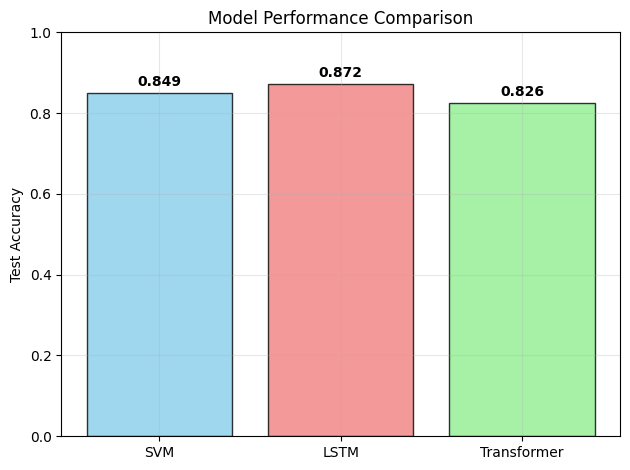


🏆 FINAL RESULTS:
Dataset: 426 time series × 89 timepoints
Classes: Balanced ([213 213])

Model Performance:
  SVM: 0.8488
  LSTM: 0.8721
  Transformer: 0.8256

🥇 Best Model: LSTM (0.8721 accuracy)


In [26]:
# Compile results
results = {
    'SVM': svm_accuracy,
    'LSTM': lstm_accuracy,
    'Transformer': transformer_accuracy
}

# Visualization
plt.figure()

# Model comparison
models = list(results.keys())
accuracies = list(results.values())
colors = ['skyblue', 'lightcoral', 'lightgreen'][:len(models)]

bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
best_model = max(results, key=results.get)
best_accuracy = results[best_model]

print(f"\n🏆 FINAL RESULTS:")
print(f"Dataset: {X.shape[0]} time series × {X.shape[1]} timepoints")
print(f"Classes: Balanced ({np.bincount(y)})")
print(f"\nModel Performance:")
for model, acc in results.items():
    print(f"  {model}: {acc:.4f}")
print(f"\n🥇 Best Model: {best_model} ({best_accuracy:.4f} accuracy)")

In [27]:
# Save results
results_df = pd.DataFrame({
    'Experiment_1': [data['exp1']['omid']],
    'Experiment_2': [data['exp2']['omid']],
    'Total_Series': [X.shape[0]],
    'Timepoints': [X.shape[1]],
    'SVM_Accuracy': [svm_accuracy],
    'LSTM_Accuracy': [lstm_accuracy],
    'Transformer_Accuracy': [transformer_accuracy],
    'Best_Model': [best_model],
    'Best_Accuracy': [best_accuracy],
})

# results_df.to_csv('classification_results_clean.csv', index=False)